## 라이브러리 가져오기

In [ ]:
import sqlite3
import pandas as pd
from datetime import datetime

## table 만들기

In [ ]:
def create_database():
  conn = sqlite3.connect("assets.db")
  cursor = conn.cursor()
  cursor.execute("""
    CREATE TABLE IF NOT EXISTS asset_data (
        timeline INTEGER,
        time TEXT,
        symbol TEXT,
        price REAL,
        volume REAL
    )
  """)
  conn.commit()
  conn.close()


create_database()

## 수정 및 추가

In [ ]:
import sqlite3
import pandas as pd

def add_new_timeline_data(new_data):
    """
    기존 데이터 중복 확인 후,
    - 동일한 `symbol`이 존재하면 `volume`을 증가
    - 없으면 기존 데이터 + 새로운 데이터를 새로운 timeline으로 복사하여 추가

    :param new_data: dict 형태의 추가할 데이터 (예: {"time": "2025-02-22 12:00:00", "symbol": "AAPL", "price": 152.3, "volume": 1200})
    """
    # 데이터베이스 연결
    conn = sqlite3.connect("assets.db")
    cursor = conn.cursor()

    # 가장 큰 timeline 찾기
    cursor.execute("SELECT MAX(timeline) FROM asset_data")
    max_timeline = cursor.fetchone()[0]

    # max_timeline이 None이면 첫 번째 데이터이므로 1로 설정
    new_timeline = 1 if max_timeline is None else max_timeline + 1

    # 동일한 `symbol`이 있는지 확인 (현재 timeline에서)
    cursor.execute("""
        SELECT volume FROM asset_data
        WHERE symbol = ? AND timeline = ?
    """, (new_data["symbol"], max_timeline))

    existing_data = cursor.fetchone()

    if existing_data:
        # 기존 volume 가져오기
        existing_volume = existing_data[0]
        updated_volume = existing_volume + new_data["volume"]

        # 기존 데이터 복사하여 timeline 증가
        df_prev = pd.read_sql_query("SELECT * FROM asset_data WHERE timeline = ?", conn, params=(max_timeline,))

        # 기존 데이터의 timeline 변경
        df_prev["timeline"] = new_timeline

        # volume 증가된 새로운 데이터 생성
        df_prev.loc[df_prev["symbol"] == new_data["symbol"], "volume"] = updated_volume

        # 데이터 삽입
        df_prev.to_sql("asset_data", conn, if_exists="append", index=False)

        print(f"같은 symbol 발견: 기존 volume({existing_volume}) + {new_data['volume']} = {updated_volume} 업데이트 후 timeline {new_timeline}으로 복사 완료!")

    else:
        # 기존 데이터 가져오기
        df_prev = pd.read_sql_query("SELECT * FROM asset_data WHERE timeline = ?", conn, params=(max_timeline,)) if max_timeline else pd.DataFrame()

        # 새로운 데이터 추가
        new_entry = {
            "timeline": new_timeline,
            "time": new_data["time"],
            "symbol": new_data["symbol"],
            "price": new_data["price"],
            "volume": new_data["volume"]
        }

        # 기존 데이터의 timeline 업데이트 후 새로운 데이터프레임 생성
        if not df_prev.empty:
            df_prev["timeline"] = new_timeline  # timeline을 새 값으로 업데이트

        # 새로운 데이터프레임 생성
        df_new = pd.DataFrame([new_entry])

        # 기존 데이터 + 새로운 데이터 합치기
        df_combined = pd.concat([df_prev, df_new], ignore_index=True)

        # 데이터 삽입
        df_combined.to_sql("asset_data", conn, if_exists="append", index=False)

        print(f"새로운 timeline {new_timeline}에 데이터 추가 완료!")

    # 연결 종료
    conn.close()

"""
# 예제 실행
new_data_example = {
    "time": "2025-02-22 12:00:00",
    "symbol": "TSLA",
    "price": 152.3,
    "volume": 1200
}
"""
#df_updated = add_new_timeline_data(new_data_example)


'\n# 예제 실행\nnew_data_example = {\n    "time": "2025-02-22 12:00:00",\n    "symbol": "TSLA",\n    "price": 152.3,\n    "volume": 1200\n}\n'

## select 값 찾기

In [ ]:
import sqlite3
import pandas as pd

def get_data_by_timeline(timeline):
    """
    특정 timeline 값에 해당하는 데이터를 검색하여 반환합니다.
    :param timeline: 검색할 timeline 값 (정수)
    :return: pandas DataFrame
    """
    conn = sqlite3.connect("assets.db")
    df = pd.read_sql_query("SELECT * FROM asset_data WHERE timeline = ?", conn, params=(timeline,))
    conn.close()
    return df

def get_data_by_symbol(symbol):
    """
    특정 symbol 값에 해당하는 데이터를 검색하여 반환합니다.
    :param symbol: 검색할 종목(symbol) 값 (문자열)
    :return: pandas DataFrame
    """
    conn = sqlite3.connect("assets.db")
    df = pd.read_sql_query("SELECT * FROM asset_data WHERE symbol = ?", conn, params=(symbol,))
    conn.close()
    return df

def get_all_data():
    """
    asset_data 테이블의 전체 데이터를 검색하여 반환합니다.
    :return: pandas DataFrame
    """
    conn = sqlite3.connect("assets.db")
    df = pd.read_sql_query("SELECT * FROM asset_data", conn)
    conn.close()
    return df

def get_max_timeline_data():
    """
    가장 큰 timeline 값을 가진 데이터를 검색하여 반환합니다.
    :return: pandas DataFrame
    """
    conn = sqlite3.connect("assets.db")
    cursor = conn.cursor()

    # 가장 큰 timeline 값 찾기
    cursor.execute("SELECT MAX(timeline) FROM asset_data")
    max_timeline = cursor.fetchone()[0]

    # max_timeline이 None이면 빈 DataFrame 반환
    if max_timeline is None:
        conn.close()
        return pd.DataFrame()

    # 해당 timeline 데이터를 DataFrame으로 가져오기
    df = pd.read_sql_query("SELECT * FROM asset_data WHERE timeline = ?", conn, params=(max_timeline,))

    conn.close()
    return df

# 예제 실행
df_timeline = get_data_by_timeline(1)
df_symbol = get_data_by_symbol("AAPL")
df_all = get_all_data()
df_max_timeline = get_max_timeline_data()



In [ ]:
import sqlite3
import pandas as pd

def delete_data_by_symbol(symbol):
    """
    특정 symbol 값을 가진 데이터를 삭제함.
    :param symbol: 삭제할 종목(symbol) 값 (문자열)
    """
    # 데이터베이스 연결
    conn = sqlite3.connect("assets.db")
    cursor = conn.cursor()

    # 특정 symbol 값 삭제
    cursor.execute("DELETE FROM asset_data WHERE symbol = ?", (symbol,))

    # 변경 사항 반영
    conn.commit()
    conn.close()

    print(f"'{symbol}' 데이터를 삭제하였습니다.")

"""
# 데이터 삭제 예제 실행
delete_data_by_symbol("TSLA")

# 새로운 데이터 추가 예제 실행
new_data_example = {
    "time": "2025-02-22 13:00:00",
    "symbol": "AAPL",
    "price": 155.7,
    "volume": 800
}

df_updated = add_new_timeline_data(new_data_example)
"""

'TSLA' 데이터를 삭제하였습니다.
새로운 timeline 5에 데이터 추가 완료!


In [ ]:
def get_current_time():
    """
    현재 시간을 'YYYY-MM-DD HH:MM:SS' 형식의 문자열로 반환
    """
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# 예제 실행
new_data_example = {
    "time": get_current_time(),
    "symbol": "TSLA",
    "price": 152.3,
    "volume": -12
}

df_updated = add_new_timeline_data(new_data_example)

같은 symbol 발견: 기존 volume(1188.0) + -12 = 1176.0 업데이트 후 timeline 3으로 복사 완료!


In [ ]:
df_max_timeline = get_max_timeline_data()
df_max_timeline

,timeline,time,symbol,price,volume
0,4,2025-02-22 12:00:00,TSLA,152.3,1176.0
1,4,2025-02-22 06:27:35,NVDA,152.3,12.0


In [ ]:
# 예제 실행
new_data_example = {
    "time": get_current_time(),
    "symbol": "NVDA",
    "price": 152.3,
    "volume": 12
}

df_updated = add_new_timeline_data(new_data_example)

새로운 timeline 4에 데이터 추가 완료!


In [ ]:
df_max_timeline = get_max_timeline_data()
df_max_timeline

,timeline,time,symbol,price,volume
0,6,2025-02-22 12:00:00,NVDA,152.3,1200.0
1,6,2025-02-22 13:00:00,AAPL,155.7,800.0
2,6,2025-02-22 12:00:00,TSLA,152.3,12.0
3,6,2025-02-22 12:00:00,NVDA,152.3,12.0
4,6,2025-02-22 12:00:00,NVDA,152.3,12.0


In [ ]:
# 예제 실행
new_data_example = {
    "time": "2025-02-22 12:00:00",
    "symbol": "TSLA",
    "price": 152.3,
    "volume": 12
}

df_updated = add_new_timeline_data(new_data_example)

중복 데이터 발견: 기존 데이터 복사 후 새로운 timeline 9으로 추가 완료!


In [ ]:
df_max_timeline = get_max_timeline_data()
df_max_timeline

,timeline,time,symbol,price,volume
0,9,2025-02-22 13:00:00,AAPL,155.7,800.0
1,9,2025-02-22 12:00:00,TSLA,152.3,12.0
2,9,2025-02-22 12:00:00,NVDA,152.3,12.0
3,9,2025-02-22 12:00:00,TSLA,152.3,12.0
4,9,2025-02-22 12:00:00,TSLA,152.3,1200.0


In [ ]:
df_max_timeline = get_max_timeline_data()

In [ ]:
df_all = get_all_data()
df_all

,timeline,time,symbol,price,volume
0,1,2025-02-22 12:00:00,TSLA,152.3,1200.0
1,2,2025-02-22 12:00:00,TSLA,152.3,1188.0
2,3,2025-02-22 12:00:00,TSLA,152.3,1176.0
3,4,2025-02-22 12:00:00,TSLA,152.3,1176.0
4,4,2025-02-22 06:27:35,NVDA,152.3,12.0


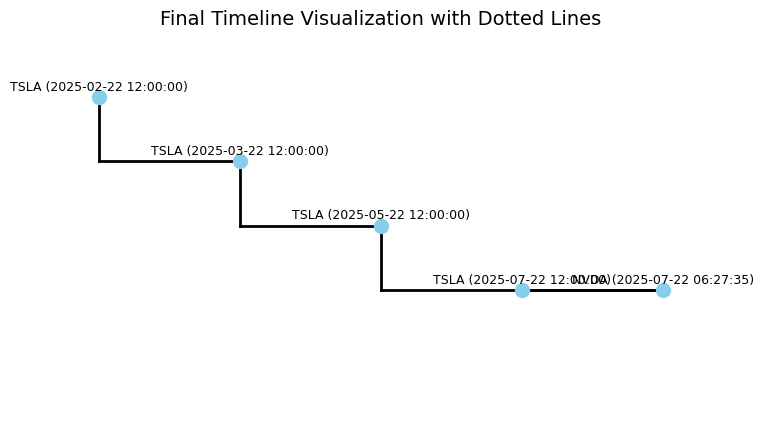